### Annual Rankings of Streamflow, SWE, ET, Soil Moisture, Precip (with anomalies)

This notebook will first build a linear regression between streamflow and SWE anomalies and compute the residual for these years and rank them. Then I will do the same for ranking years with annual ET signals, seasonal ET signals, winter, spring, and summer precip signals and fall soil moisture signals. Then I will look at how these years align with each other. 

This will cover the Water Years 1987 to 2020

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import datetime as dt

import rioxarray as rioxr
from rasterio.enums import Resampling
import geopandas as gpd 
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

import seaborn as sns
import matplotlib.pyplot as plt
import xoak
import nctoolkit as nc
from dataretrieval import nwis
from scipy import stats


/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


nctoolkit is using Climate Data Operators version 2.1.0


In [2]:
# Polygon for Taylor River
taylor_taylor_polygon = gpd.read_file('../multisite/polygons/east_taylor.json')
taylor_river_polygon = taylor_taylor_polygon[taylor_taylor_polygon['name']=='Taylor River']

### Pull in Snotel data and streamflow data

In [3]:
# Import snotel data
er_sntl_data = xr.open_dataset('/storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [4]:
# normalized peak SWE
# create mean dataset for upper taylor (since 2011) and park_cone
park_cone_mean_ds = er_sntl_data.sel(Location=['ParkCone_680:CO:SNTL']).mean(dim='Location')
park_cone_mean_ds_filtered = park_cone_mean_ds.sel(Date=slice('1986-10-01', '2021-09-30'))

park_cone_mean_peak_swe = park_cone_mean_ds_filtered.WTEQ.groupby(park_cone_mean_ds_filtered.WY).max()
normalized_sntl_peak_swe = ((park_cone_mean_peak_swe - park_cone_mean_peak_swe.mean())/park_cone_mean_peak_swe.std()).to_dataframe()


# Upper Taylor
upper_taylor_mean_ds = er_sntl_data.sel(Location=['UpperTaylor_737:CO:SNTL']).mean(dim='Location')
upper_taylor_mean_ds_filtered = upper_taylor_mean_ds.sel(Date=slice('1986-10-01', '2021-09-30'))
upper_taylor_april_1_swe = upper_taylor_mean_ds_filtered.where((upper_taylor_mean_ds_filtered.Date.dt.month==4) & (upper_taylor_mean_ds_filtered.Date.dt.day==1)).WTEQ.to_dataframe().dropna()
upper_taylor_april_1_swe = upper_taylor_april_1_swe.WTEQ.groupby(upper_taylor_april_1_swe.WY).mean()
normalized_upper_taylor_april_1_swe = ((upper_taylor_april_1_swe - upper_taylor_april_1_swe.mean())/upper_taylor_april_1_swe.std())

# Park Cone
park_cone_april_1_swe = park_cone_mean_ds_filtered.where((park_cone_mean_ds_filtered.Date.dt.month==4) & (park_cone_mean_ds_filtered.Date.dt.day==1)).WTEQ.to_dataframe().dropna()
park_cone_april_1_swe = park_cone_mean_ds_filtered.WTEQ.groupby(park_cone_mean_ds_filtered.WY).mean()
normalized_april_1_swe = ((park_cone_april_1_swe - park_cone_april_1_swe.mean())/park_cone_april_1_swe.std()).to_dataframe()

normalized_april_1_swe = pd.concat([normalized_april_1_swe,normalized_upper_taylor_april_1_swe], axis=1).mean(axis=1)

In [5]:
park_cone_df = park_cone_mean_ds_filtered.WTEQ.to_dataframe()
park_cone_idx_max = park_cone_df['WTEQ'].groupby(park_cone_df.WY).idxmax()
park_cone_idx_max_doy= pd.to_datetime(park_cone_idx_max.values).dayofyear
park_cone_idx_max_df = pd.DataFrame(park_cone_idx_max_doy, index=park_cone_idx_max.index, columns=['peak_swe_doy'])
norm_park_cone_idx_max_df = (park_cone_idx_max_df-park_cone_idx_max_df.mean())/park_cone_idx_max_df.std()

In [6]:
taylor_usgs_taylorpark = '09107000'

# get streamflow data from taylor river at almont
taylor_river_discharge_almont_dv = nwis.get_record(taylor_usgs_taylorpark, start='1986-10-1', service='dv')['00060_Mean']

# Filter out until the end of our dataset
taylor_river_discharge_almont_dv = taylor_river_discharge_almont_dv.loc[:'2021-09-30']
# Filter out -9999 values
taylor_river_discharge_almont_dv = taylor_river_discharge_almont_dv[taylor_river_discharge_almont_dv>=0]

# Average to monthly values
taylor_river_discharge_almont_monthly = taylor_river_discharge_almont_dv.groupby(pd.Grouper(freq='M')).mean()
taylor_river_discharge_almont_monthly.index = pd.to_datetime(taylor_river_discharge_almont_monthly.index.date)

# Set index as datetime
taylor_river_discharge_almont_dv.index = pd.to_datetime(taylor_river_discharge_almont_dv.index).date
taylor_river_discharge_almont_dv.index = pd.to_datetime(taylor_river_discharge_almont_dv.index)

# Rename the series
taylor_river_discharge_almont_monthly.name = 'mean_discharge'

# Convert to dataframe and add in water year column
taylor_river_discharge_almont_monthly = taylor_river_discharge_almont_monthly.to_frame()
taylor_river_discharge_almont_monthly['WY'] = taylor_river_discharge_almont_monthly.index.year.where(taylor_river_discharge_almont_monthly.index.month < 10, taylor_river_discharge_almont_monthly.index.year + 1)

# create annual product
taylor_river_discharge_almont_annual = taylor_river_discharge_almont_monthly.groupby(taylor_river_discharge_almont_monthly['WY']).mean()
taylor_river_discharge_almont_annual_peak = taylor_river_discharge_almont_monthly.groupby(taylor_river_discharge_almont_monthly['WY']).max()

# create seasonal product 

# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.index.dt.days_in_month

    # Calculate the weighted average
    return (ds * month_length).resample(index='QS-JAN').sum() / month_length.resample(index='QS-JAN').sum()

taylor_river_discharge_almont_monthly_ds = taylor_river_discharge_almont_monthly.to_xarray()
taylor_river_discharge_almont_seasonal_ds = season_mean(taylor_river_discharge_almont_monthly_ds)
taylor_river_discharge_almont_seasonal_ds['WY'] = np.ceil(taylor_river_discharge_almont_seasonal_ds['WY'])
taylor_river_discharge_almont_spring_ds = taylor_river_discharge_almont_seasonal_ds.where(taylor_river_discharge_almont_seasonal_ds.index.dt.month==4)
taylor_river_discharge_almont_spring = taylor_river_discharge_almont_spring_ds.dropna(dim='index').to_pandas().set_index('WY')

Text(0.5, 0, 'Day of WY')

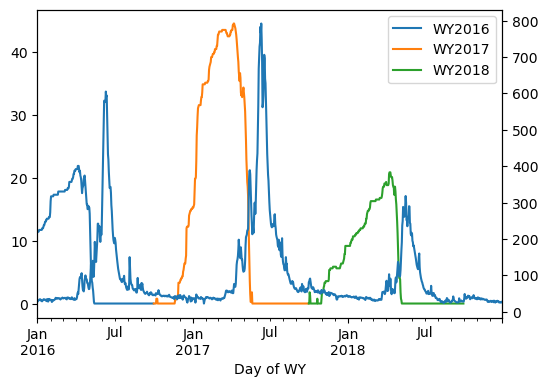

In [7]:
park_cone_2016 = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered['WY']==2016).to_dataframe()
park_cone_2017 = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered['WY']==2017).to_dataframe()
park_cone_2018 = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered['WY']==2018).to_dataframe()

fig, ax = plt.subplots(figsize=(6,4))

park_cone_2016['WTEQ'].plot(label='WY2016',ax=ax)
park_cone_2017['WTEQ'].plot(label='WY2017',ax=ax)
park_cone_2018['WTEQ'].plot(label='WY2018',ax=ax)
ax2 = ax.twinx()
taylor_river_discharge_almont_dv[taylor_river_discharge_almont_dv.index.year.isin([2016,2017,2018])].plot(ax=ax2)
ax.legend()
ax.set_xlabel('Day of WY')

In [8]:
# Create time frame of mean discharge from peak SWE to peak streamflow
peak_swe_peak_q = {}
peak_swe_peak_q_len = {}
for year in np.unique(park_cone_mean_ds_filtered.Date.dt.year.values):
    # if year not in [1986,2015]:
    if year not in [1986]:
        # Filter to each year
        tmp_swe = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered.Date.dt.year==year)['WTEQ'].dropna(dim='Date')
        tmp_q =  taylor_river_discharge_almont_dv[taylor_river_discharge_almont_dv.index.year==year]
        # calculate maximum swe date
        peak_swe_date = tmp_swe.idxmax().values
        peak_q_date = tmp_q.idxmax()

        # calculate mean over peak swe to peak q 
        tmp_q_filter = tmp_q.loc[peak_swe_date:peak_q_date]
        # add mean to dict
        peak_swe_peak_q[year] = tmp_q_filter.mean()
        peak_swe_peak_q_len[year] = len(tmp_q_filter)
       
peak_swe_peak_q_df = pd.Series(peak_swe_peak_q)
peak_swe_peak_q_len_df = pd.Series(peak_swe_peak_q_len)

In [9]:
# Create time frame of mean discharge from April 1 SWE to September 30 SWE
april_1_sep_30_q = {}

for year in np.unique(park_cone_mean_ds_filtered.Date.dt.year.values):
    if year not in [1986]:
        # Filter to each year
        tmp_q =  taylor_river_discharge_almont_dv[taylor_river_discharge_almont_dv.index.year==year]
        start = dt.date(year,4,1)
        end  = dt.date(year,9,30)

        # calculate mean over peak swe to peak q 
        tmp_q_filter = tmp_q.loc[start:end]
        # add mean to dict
        april_1_sep_30_q[year] = tmp_q_filter.mean()
       
april_1_sep_30_q_df = pd.Series(april_1_sep_30_q)

### Linear relationship between Streamflow and SWE

In [10]:
# normalized streamflow
normalized_er_spring_q = (taylor_river_discharge_almont_spring - taylor_river_discharge_almont_spring.mean())/ taylor_river_discharge_almont_spring.std()
normalized_er_annual_q = (taylor_river_discharge_almont_annual - taylor_river_discharge_almont_annual.mean())/ taylor_river_discharge_almont_annual.std()
normalized_er_peakswe_peak_q = (peak_swe_peak_q_df-peak_swe_peak_q_df.mean())/peak_swe_peak_q_df.std()
normalized_er_apr1_sep30_q = (april_1_sep_30_q_df-april_1_sep_30_q_df.mean())/april_1_sep_30_q_df.std()

In [11]:
slope, intercept, rvalue, pvalue,stderr  = stats.linregress(normalized_april_1_swe.iloc[1:], normalized_er_apr1_sep30_q.iloc[1:])#['mean_discharge'])

alpha = 0.05
c = (1 - alpha)

# Create regression line and residuals
X = normalized_april_1_swe
y_predicted = intercept + slope*X
residual = (normalized_er_apr1_sep30_q-y_predicted)

# Setup 
n = X.size                                               
dof = n - 2
t = stats.t.ppf(c, dof) 

# sum of squared errors
sse = np.sum(residual**2)

# total sum of squares (y)
sst = np.sum( (normalized_er_apr1_sep30_q - np.mean(normalized_er_apr1_sep30_q))**2 )

# total sum of squares (x)
sst_x = np.sum( (X - np.mean(X))**2 )

# correlation coefficient
r_squared = 1 - sse/sst

# standard error of regression
s = np.sqrt(sse/(n-2))

# an array of x values
p_x = np.linspace(X.min(),X.max(),100)

# using our model parameters to predict y values
p_y = intercept + slope*p_x

# compute error of prediction for each p_x
sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
# set our confidence interval

p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep


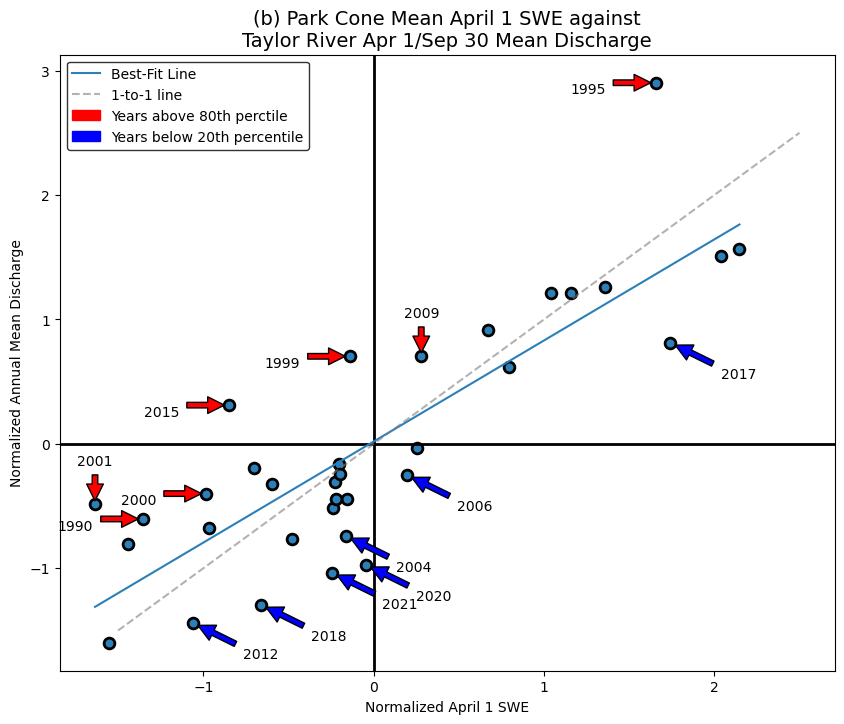

In [12]:
fig, ax = plt.subplots(ncols=1, figsize=(10,8))
colors = ['#2c7fb8','#7fcdbb']
residual=residual.dropna()
idx_20th_percentile = (residual[residual < np.percentile(residual,20)].index).astype(int)
idx_80th_percentile = (residual[residual > np.percentile(residual,80)].index).astype(int)

ax.scatter(normalized_april_1_swe, normalized_er_apr1_sep30_q, color=colors[0], edgecolor='k', s=60, lw=2)
ax.axhline(0, color='k', lw=2)
ax.axvline(0, color='k', lw=2)
ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line')
ax.plot([-1.5,2.5],[-1.5,2.5], label='1-to-1 line', color='grey', ls='--', alpha=0.6)
# ax.plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
# ax.plot(p_x, p_y_upper, color=colors[1], ls='--', )
# ax.fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)


for i,idx in enumerate(idx_20th_percentile):

    ax.annotate(str(idx), 
                    (normalized_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]),
                    (normalized_april_1_swe.loc[idx]+0.4, normalized_er_apr1_sep30_q.loc[idx]-0.2),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_80th_percentile):
    if idx in [2001,2009]:
        ax.annotate(str(idx), 
                (normalized_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]),
                (normalized_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]+0.4),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        
    else:
        ax.annotate(str(idx), 
                (normalized_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]),
                (normalized_april_1_swe.loc[idx]-0.4, normalized_er_apr1_sep30_q.loc[idx]),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

ax.arrow([],[],[],[], color='red', label='Years above 80th perctile',width=0.1)
ax.arrow([],[],[],[], color='blue', label='Years below 20th percentile',width=0.1)
ax.set_xlabel('Normalized April 1 SWE')
ax.set_ylabel('Normalized Annual Mean Discharge')
ax.set_title('(b) Park Cone Mean April 1 SWE against\nTaylor River Apr 1/Sep 30 Mean Discharge', size=14)
ax.legend(edgecolor='k', facecolor='white')

Text(0.5, 1.0, 'Taylor River SWE-Q Residual Histogram')

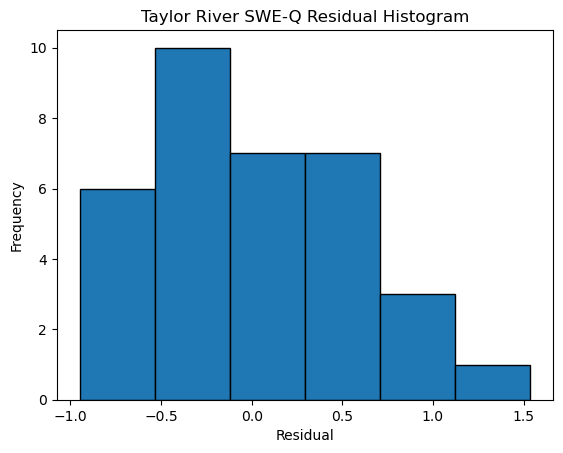

In [15]:
fig, ax = plt.subplots()
residual.plot.hist(ax=ax, bins=6, density=False, ec='k')
ax.set_xlabel('Residual')
ax.set_title('Taylor River SWE-Q Residual Histogram')

Text(0, 0.5, 'SWE - Q Residual')

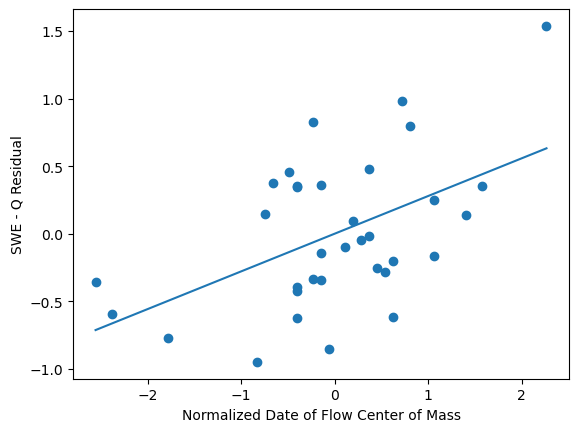

In [19]:
com_date = {}
taylor_river_discharge_almont_dv_dowy = pd.DataFrame(taylor_river_discharge_almont_dv)
taylor_river_discharge_almont_dv_dowy['WY'] = taylor_river_discharge_almont_dv_dowy.index.year.where(taylor_river_discharge_almont_dv_dowy.index.month < 10, taylor_river_discharge_almont_dv_dowy.index.year + 1)
for year in taylor_river_discharge_almont_dv_dowy.WY:
    cumsum = taylor_river_discharge_almont_dv_dowy[taylor_river_discharge_almont_dv_dowy.WY == year].cumsum()
    com = (np.abs(cumsum['00060_Mean']-(cumsum['00060_Mean'].max()/2))).idxmin().day_of_year
    com_date[year] = com
center_of_mass_date = pd.Series(com_date)

norm_com = (center_of_mass_date-center_of_mass_date.mean())/center_of_mass_date.std()
slope, intercept, rvalue, pvalue,stderr  = stats.linregress(norm_com, residual)#['mean_discharge'])
plt.scatter(norm_com,residual)
plt.plot([norm_com.min(),norm_com.max()], slope*np.array([norm_com.min(),norm_com.max()]+intercept))
plt.xlabel('Normalized Date of Flow Center of Mass')
plt.ylabel('SWE - Q Residual')

### Calculate snow melt season length and sort by years

In [37]:
# melt season length dictionary
melt_season_length_dict = {}
snow_melt_date_dict = {}

# iterate through each year to calculate the WY melt season length
for year in np.unique(park_cone_mean_ds_filtered.Date.dt.year.values):
    # if year not in [1986,2015]:
    if year not in [1986]:
        # Filter to each year
        tmp = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered.Date.dt.year==year)['WTEQ'].dropna(dim='Date')
        # calculate maximum swe date
        peak_swe_date = tmp.idxmax().values
        # calculate peak swe value
        peak_swe = tmp.max()
        # calculate weekly rolling average
        weekly_rolling_mean = tmp.rolling(Date=7).mean()
        # first date where rolling weekly average is < 5% of Peak SWE  is considered snow melt date
        snow_melt_date = weekly_rolling_mean.where(weekly_rolling_mean==0).dropna(dim='Date')[0].Date.values
        # difference in time between peak and melt is snow melt season length
        melt_season_length = (snow_melt_date - peak_swe_date).astype('timedelta64[D]').astype(np.int32)
        # add to disctionary
        melt_season_length_dict[year] = melt_season_length
        snow_melt_date_dict[year] = pd.Timestamp(snow_melt_date).day_of_year
# create series of melt season length
melt_season_len_days = pd.Series(melt_season_length_dict.values(), index = melt_season_length_dict.keys(), name='melt_season_length')
sdd = pd.Series(snow_melt_date_dict.values(), index = snow_melt_date_dict.keys(), name='snow_dissapearance_date')
norm_melt_season_len = (melt_season_len_days - melt_season_len_days.mean())/melt_season_len_days.std()
norm_sdd = (sdd - sdd.mean())/sdd.std()

In [38]:
norm_melt_season_sorted = norm_melt_season_len.iloc[1:].sort_values()

In [39]:
# Spearman rank coefficent for melt season length
stats.spearmanr(norm_melt_season_sorted.index, sorted_residual.index)

SignificanceResult(statistic=0.08724216959511077, pvalue=0.6236992135854981)

In [40]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(norm_sdd.iloc[1:].sort_values().index, sorted_residual.index)

SignificanceResult(statistic=-0.20488922841864018, pvalue=0.2450750660994493)

Text(0.5, 0.98, 'Park Cone')

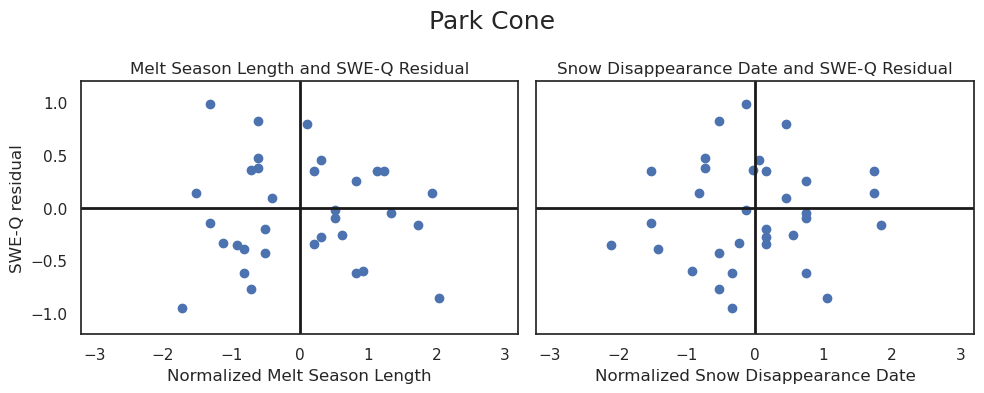

In [41]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10,4), sharey=True)

axs[0].scatter(norm_melt_season_len.iloc[1:].values,residual.values)
axs[0].set_xlabel('Normalized Melt Season Length')
axs[0].set_ylabel('SWE-Q residual')
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
axs[0].set_xlim(-3.2,3.2)
axs[0].set_ylim(-1.2,1.2)
axs[0].set_title('Melt Season Length and SWE-Q Residual', size=12)

axs[1].scatter(norm_sdd.iloc[1:].values,residual.values)
axs[1].set_xlabel('Normalized Snow Disappearance Date')
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlim(-3.2,3.2)
axs[1].set_ylim(-1.2,1.2)
axs[1].set_title('Snow Disappearance Date and SWE-Q Residual', size=12)

fig.suptitle('Park Cone', size=18)

This does not really tell me much about the relationship between melt season length and the SWE-Q residual. A relationship does not seem to appear. Why might this be? It does not tell me anything about the timing of snow dissappearance. Perhaps snow disappearance date is more what I want. A shorter melt season would be expected to have to counteracting situations: 
1) signifies a warmer period during spring which could start up ET a bit earlier and remove more water, especially if the antecedent soil moisture was low
2) signifies rapid melt out, which may both saturate the soils and lead to overland flow, causing increased SWE-Q relationship

2015 had less than average snowfall, but greater than average streamflow, why might this be? Snowmelt season was rather drawn out and was well above average in length. Was it cold over this period? How much rain in spring was there? How strong was the monsoon? How saturated were soils in the fall?

# Remaining Things to Look at
- Signals for basin wide fall soil moisture
- Signals from fall, winter, and spring ET
- Signals from fall, winter, and spring SWE/Precip?
- Snow dissapearnce date

### Signals of Annual Precipitation

In [42]:
wrf_climatology_ds = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology_precip_taylor.nc')

In [43]:
wrf_climatology_precip = wrf_climatology_ds.where(wrf_climatology_ds['TAYLOR_MASK']==True)['precip'].mean(dim=['south_north','west_east']).to_dataframe()
# Drop 1987
wrf_climatology_precip = wrf_climatology_precip[wrf_climatology_precip['WY']!=1987]
wrf_annual_precip = wrf_climatology_precip.groupby(wrf_climatology_precip['WY']).sum()
norm_wrf_annual_precip = (wrf_annual_precip-wrf_annual_precip.mean())/wrf_annual_precip.std()

sorted_annual_precip = norm_wrf_annual_precip.sort_values(by='precip')
sorted_annual_precip_top_5 = sorted_annual_precip[:5].index.values


### Signals of Seasonal Precipiation

In [44]:
def season_mean_df(df, calendar="standard", column=None):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    df['month_length'] = df.index.days_in_month
    # Calculate the weighted average
    return (df[column]* df['month_length']).resample('Q-NOV', convention='end').agg('sum') / df['month_length'].resample('Q-NOV', convention='end').agg('sum')

In [45]:
stand_anomalies_precip_seasonal_df  = season_mean_df(wrf_climatology_precip, column='precip').to_frame(name='precip')
norm_anomalies_precip_seasonal_df = stand_anomalies_precip_seasonal_df.groupby(stand_anomalies_precip_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std())
norm_anomalies_precip_seasonal_df.index = pd.to_datetime(norm_anomalies_precip_seasonal_df.index)
norm_anomalies_precip_seasonal_df['WY']=norm_anomalies_precip_seasonal_df.index.year.where(norm_anomalies_precip_seasonal_df.index.month<10,norm_anomalies_precip_seasonal_df.index.year+1)

In [46]:
sorted_summer_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==8]
sorted_summer_precip_top_5 = sorted_summer_precip.sort_values(by='precip')[:5]['WY'].values

sorted_fall_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==11]
sorted_fall_precip_top_5 = sorted_fall_precip.sort_values(by='precip')[:5]['WY'].values

sorted_winter_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==2]
sorted_winter_precip_top_5 = sorted_winter_precip.sort_values(by='precip')[:5]['WY'].values

sorted_spring_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==5]
sorted_spring_precip_top_5 = sorted_spring_precip.sort_values(by='precip')[:5]['WY'].values

In [47]:
# Spearman rank coefficent for seasonal ET
print(stats.spearmanr(sorted_fall_precip.sort_values(by='precip').WY, sorted_residual.index))
print(stats.spearmanr(sorted_spring_precip.sort_values(by='precip').WY, sorted_residual.drop(2021).index))
print(stats.spearmanr(sorted_winter_precip.sort_values(by='precip').WY, sorted_residual.drop(2021).index))
print(stats.spearmanr(sorted_summer_precip.sort_values(by='precip').WY, sorted_residual.drop(2021).index))

SignificanceResult(statistic=-0.494576012223071, pvalue=0.0029460061238698334)
SignificanceResult(statistic=-0.1019385026737968, pvalue=0.572423067803052)
SignificanceResult(statistic=-0.1524064171122995, pvalue=0.3971553911306439)
SignificanceResult(statistic=-0.38836898395721925, pvalue=0.025517448136885383)


In [48]:
sorted_fall_precip.sort_values(by='precip').WY.values

array([1990, 2002, 1988, 1994, 1989, 2009, 2013, 2020, 1992, 2000, 2010,
       1996, 2016, 2018, 1997, 2021, 2001, 2005, 2019, 2008, 2012, 2011,
       1999, 1993, 1995, 2006, 2003, 2015, 2004, 2017, 1991, 2007, 1998,
       2014])

In [49]:
sorted_residual.index

Int64Index([2020, 2021, 2018, 2004, 2017, 2012, 2006, 1992, 2002, 2003, 1998,
            2016, 2005, 1997, 2008, 1989, 2010, 2014, 1991, 2013, 2011, 2007,
            1993, 1988, 2019, 1996, 1994, 2000, 2009, 1990, 1999, 2001, 2015,
            1995],
           dtype='int64')

Fall
Winter
Spring
Summer


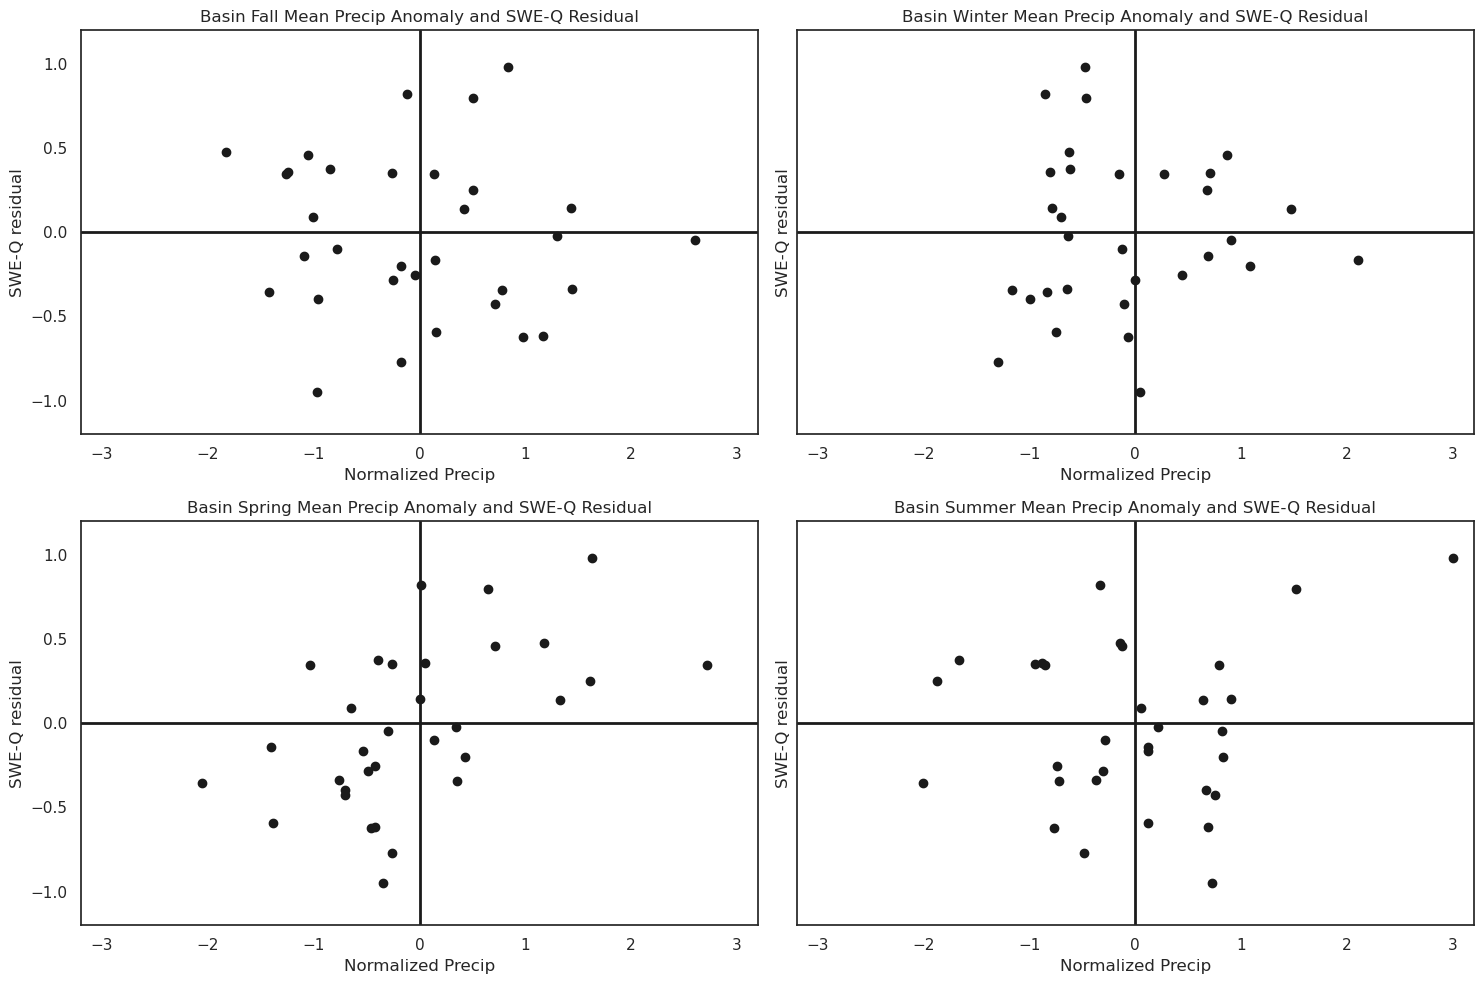

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, sharey=True, figsize=(15,10))

axs = axs.ravel()
seasons = {
    'Fall':sorted_fall_precip['precip'][:-1],
    'Winter':sorted_winter_precip['precip'],
    'Spring':sorted_spring_precip['precip'],
    'Summer':sorted_summer_precip['precip']
}

for i,ax in enumerate(axs):
    season = list(seasons.keys())[i]
    print(season)
    ax.scatter(list(seasons.values())[i],residual.iloc[:-1], color='k')
    ax.set_title(f'Basin {season} Mean Precip Anomaly and SWE-Q Residual')
    ax.set_ylabel('SWE-Q residual')
    ax.set_xlabel(f'Normalized Precip')
    ax.axhline(0, color='k', lw=2)
    ax.axvline(0, color='k', lw=2)
    ax.set_xlim(-3.2,3.2)
    ax.set_ylim(-1.2,1.2)

### Signals of Upper taylor River Basin Wide Fall Soil Moisture

In [51]:
cbrfc_sm = rioxr.open_rasterio('/storage/dlhogan/sos/data/cbrfc_fall_soil_product.nc')
cbrfc_sm = cbrfc_sm.rio.set_crs('EPSG:4326')
cbrfc_sm_rpj = cbrfc_sm.rio.reproject(taylor_river_polygon.crs, resampling=Resampling.cubic)
er_cbrfc_sm_rpj = cbrfc_sm_rpj.rio.clip(taylor_river_polygon.geometry)

In [52]:
# Normalized anomaly of basin mean fall soil moisture percent from normal
er_cbrfc_sm_rpj_basin_mean = er_cbrfc_sm_rpj.sel(year=slice(1987,2020)).mean(dim='x').mean(dim='y')
norm_er_cbrfc_rpj_basin_mean = (er_cbrfc_sm_rpj_basin_mean-er_cbrfc_sm_rpj_basin_mean.mean())/er_cbrfc_sm_rpj_basin_mean.std()

In [53]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].index.sort_values(), sorted_residual.index)

SignificanceResult(statistic=-0.3919022154316272, pvalue=0.02189148393603834)

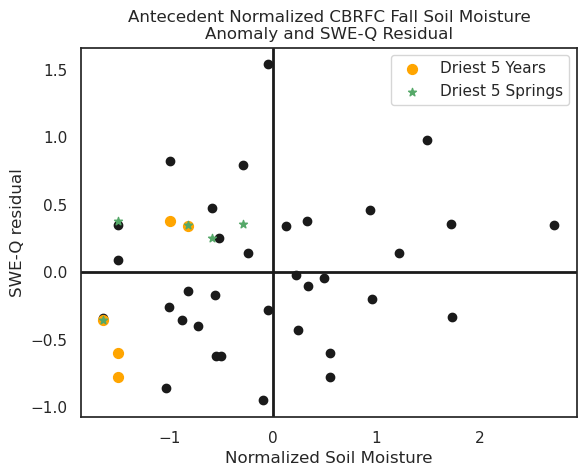

In [54]:
plt.scatter(norm_er_cbrfc_rpj_basin_mean,residual, color='k')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_annual_precip_top_5],residual.loc[sorted_annual_precip_top_5], color='orange',s=50,label='Driest 5 Years')
# plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_summer_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='r', s=30, label='Driest 5 Summers')
# plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_fall_precip_top_5],residual.loc[sorted_fall_precip_top_5], color='orange', s=30, label='Driest 5 Falls')
# plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_winter_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='b', s=30, label='Driest 5 Winters')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_spring_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='g',s=35,label='Driest 5 Springs', marker='*')


plt.title('Antecedent Normalized CBRFC Fall Soil Moisture\nAnomaly and SWE-Q Residual')
plt.ylabel('SWE-Q residual')
plt.xlabel('Normalized Soil Moisture')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)
plt.legend()

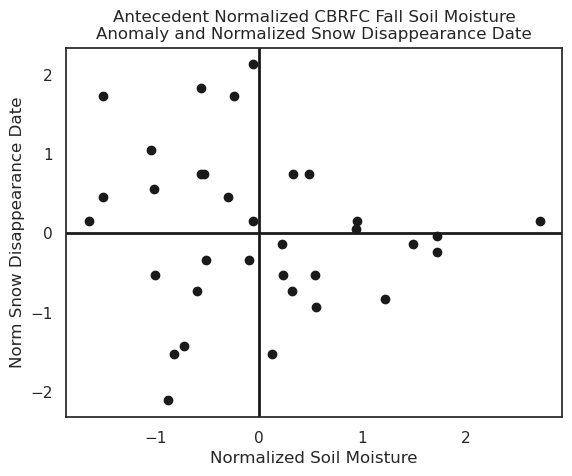

In [55]:
plt.scatter(norm_er_cbrfc_rpj_basin_mean,norm_sdd.iloc[1:], color='k')

plt.title('Antecedent Normalized CBRFC Fall Soil Moisture\nAnomaly and Normalized Snow Disappearance Date')
plt.ylabel('Norm Snow Disappearance Date')
plt.xlabel('Normalized Soil Moisture')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)

### Pull in MERRA-2 Data

In [56]:
# ds = xr.open_mfdataset('/storage/dlhogan/sos/data/merra_2/*.nc4', engine='netcdf4')
# # Get the centroid of the taylor River basin in order to filter on this 
# centroid = taylor_river_polygon.centroid

# # Add a CRS and reproject
# ds = ds.rio.write_crs('EPSG:4326')
# ds = ds.rio.set_spatial_dims(x_dim='lon',y_dim='lat')
# merra2_sm_rpj = ds.rio.reproject(taylor_river_polygon.crs, resampling=Resampling.cubic)

# # Filter to the centroid of the taylor river, this will give me one overlapping data point.
# er_merra2_sm_rpj = merra2_sm_rpj.sel(x = centroid.x[0], method='nearest').sel(y = centroid.y[0], method='nearest')
# er_merra2_sm_rpj = er_merra2_sm_rpj.sel(time=slice('1986-10-1','2020-09-30'))

In [57]:
# #Quick visualization of what this looks like
# fig, ax = plt.subplots()
# merra2_sm_rpj.isel(time=1)['GWETROOT'].plot.imshow(ax=ax)
# ax.scatter(er_merra2_sm_rpj.x,er_merra2_sm_rpj.y, s=1000, color='r')
# taylor_river_polygon.plot(ax=ax)

In [58]:
# # Build the monthly anomaly dataset
# norm_merra2_er_sm = xr.apply_ufunc(
#     lambda x, mean,std: (x - mean)/std, 
#     er_merra2_sm_rpj['GWETROOT'].groupby('time.month'),
#     er_merra2_sm_rpj['GWETROOT'].groupby('time.month').mean(),
#     er_merra2_sm_rpj['GWETROOT'].groupby('time.month').std(),
#     dask='parallelized'
# ).drop('month').to_dataframe()
# norm_merra2_er_sm.index = norm_merra2_er_sm.index.date
# norm_merra2_er_sm.index = pd.to_datetime(norm_merra2_er_sm.index)
# norm_merra2_er_sm['WY']=norm_merra2_er_sm.index.year.where(norm_merra2_er_sm.index.month<10,norm_merra2_er_sm.index.year+1)

In [59]:
# test_df = season_mean_df(norm_merra2_er_sm, column='GWETROOT').to_frame(name='GWETROOT')
# test_2_df = test_df.groupby(test_df.index.month).transform(lambda x: (x-x.mean())/x.std())

In [60]:
# # Compile into seasonal anomalies of soil moisture
# er_merra2_sm_seasonal_df = season_mean_df(er_merra2_sm_rpj.to_dataframe(), column='GWETROOT').to_frame(name='GWETROOT')
# norm_er_merra2_sm_seasonal_df = er_merra2_sm_seasonal_df.groupby(er_merra2_sm_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std()).interpolate(method='linear') #interpolate missing years
# norm_er_merra2_sm_seasonal_df.index = pd.to_datetime(norm_er_merra2_sm_seasonal_df.index)
# norm_er_merra2_sm_seasonal_df['WY']=norm_er_merra2_sm_seasonal_df.index.year.where(norm_er_merra2_sm_seasonal_df.index.month<10,norm_er_merra2_sm_seasonal_df.index.year+1)
# norm_er_merra2_sm_seasonal_df['GWETROOT'].plot()

In [61]:
# # Compare how different seasonal means correlate to SWE-Q

# fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, sharey=True, figsize=(12,10))

# axs = axs.ravel()
# seasons = {
#     'Fall':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==9]['GWETROOT'],
#     'Winter':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==12]['GWETROOT'],
#     'Spring':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==3]['GWETROOT'],
#     'Summer':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==6]['GWETROOT']
# }

# for i,ax in enumerate(axs):
#     ax.scatter(list(seasons.values())[i],residual, color='k')
#     ax.set_title(f'Basin {list(seasons.keys())[i]} Mean MERRA-2 Soil Moisture Anomaly\nand SWE-Q Residual')
#     ax.set_ylabel('SWE-Q residual')
#     ax.set_xlabel(f'Normalized MERRA-2 Soil Moisture')
#     ax.axhline(0, color='k', lw=2)
#     ax.axvline(0, color='k', lw=2)
#     ax.set_xlim(-3.2,3.2)
#     ax.set_ylim(-1.2,1.2)

### Signals of Annual ET

In [62]:
wrf_climatology_et = wrf_climatology_ds.where(wrf_climatology_ds['TAYLOR_MASK']==True)['ET_rate'].mean(dim=['south_north','west_east']).to_dataframe()
wrf_climatology_et = wrf_climatology_et[wrf_climatology_et['WY']!=1987]
wrf_annual_et = wrf_climatology_et.groupby(wrf_climatology_et['WY']).sum()
norm_wrf_annual_et = (wrf_annual_et-wrf_annual_et.mean())/wrf_annual_et.std()

sorted_annual_et = norm_wrf_annual_et.sort_values(by='ET_rate')
sorted_annual_et_top_5 = sorted_annual_et[-5:].index.values


In [63]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(sorted_annual_et.index, sorted_residual[sorted_residual.index!=2021].index)

SignificanceResult(statistic=0.14371657754010697, pvalue=0.4249224051589565)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


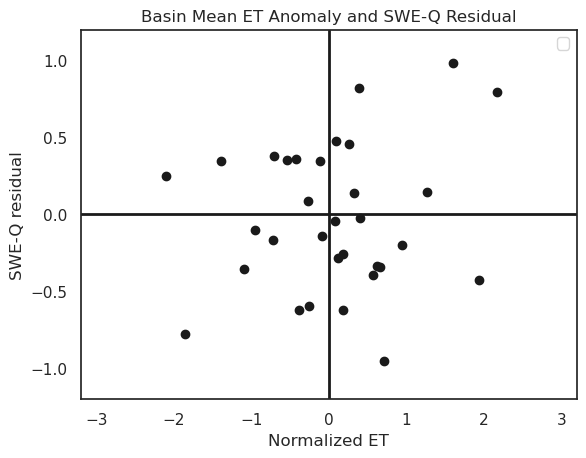

In [64]:
plt.scatter(norm_wrf_annual_et,residual.iloc[:-1], color='k')

plt.title('Basin Mean ET Anomaly and SWE-Q Residual')
plt.ylabel('SWE-Q residual')
plt.xlabel('Normalized ET')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)
plt.xlim(-3.2, 3.2)
plt.ylim(-1.2,1.2)
plt.legend()

(-3.2, 3.2)

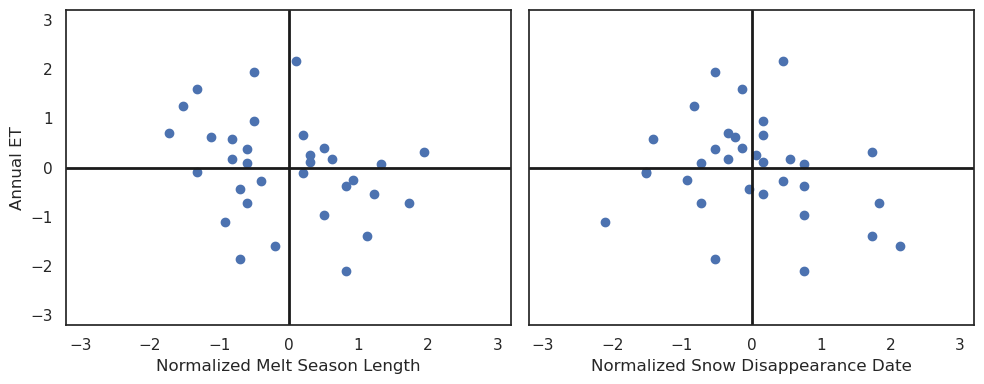

In [65]:

fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10,4), sharey=True)

axs[0].scatter(norm_melt_season_len[~norm_melt_season_len.index.isin([1987,2021])].values,norm_wrf_annual_et.values)
axs[0].set_xlabel('Normalized Melt Season Length')
axs[0].set_ylabel('Annual ET')
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
axs[0].set_xlim(-3.2,3.2)
axs[0].set_ylim(-3.2,3.2)

axs[1].scatter(norm_sdd[~norm_sdd.index.isin([1987,2021])].values,norm_wrf_annual_et.values)
axs[1].set_xlabel('Normalized Snow Disappearance Date')
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlim(-3.2,3.2)
axs[1].set_ylim(-3.2,3.2)

### Signals of Season Sublimation/Evaporation

In [66]:
stand_anomalies_et_seasonal_df  = season_mean_df(wrf_climatology_et, column='ET_rate').to_frame(name='ET_rate')
norm_anomalies_et_seasonal_df = stand_anomalies_et_seasonal_df.groupby(stand_anomalies_et_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std())
norm_anomalies_et_seasonal_df.index = pd.to_datetime(norm_anomalies_et_seasonal_df.index)
norm_anomalies_et_seasonal_df['WY']=norm_anomalies_et_seasonal_df.index.year.where(norm_anomalies_et_seasonal_df.index.month<10,norm_anomalies_et_seasonal_df.index.year+1)

In [67]:
# Spearman rank coefficent for seasonal ET
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==8].sort_values(by='ET_rate').WY, sorted_residual.index[sorted_residual.index!=2021]))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==11].iloc[1:].sort_values(by='ET_rate').WY, sorted_residual.index[sorted_residual.index!=2021]))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2].sort_values(by='ET_rate').WY, sorted_residual.index[sorted_residual.index!=2021]))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5].sort_values(by='ET_rate').WY, sorted_residual.index[sorted_residual.index!=2021]))

SignificanceResult(statistic=-0.06283422459893048, pvalue=0.7283052128479877)
SignificanceResult(statistic=0.02339572192513369, pvalue=0.8971728827314497)
SignificanceResult(statistic=0.2767379679144385, pvalue=0.11898063506183351)
SignificanceResult(statistic=0.22827540106951874, pvalue=0.2013451332955642)


Text(0, 0.5, 'Normalized Basin Mean ET')

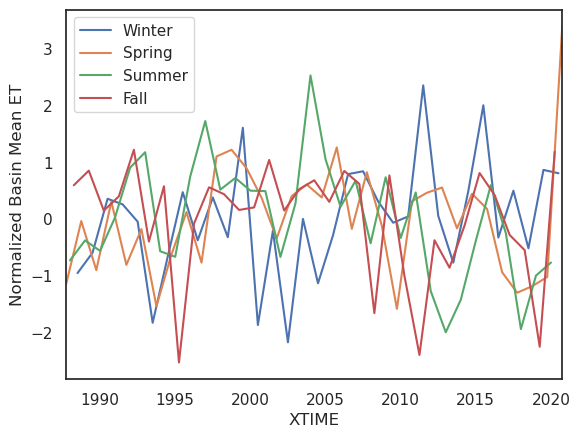

In [68]:
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==8]['ET_rate'].plot(label='Winter')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==11]['ET_rate'].plot(label='Spring')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2]['ET_rate'].plot(label='Summer')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5]['ET_rate'].plot(label='Fall')
plt.legend()
plt.ylabel('Normalized Basin Mean ET')

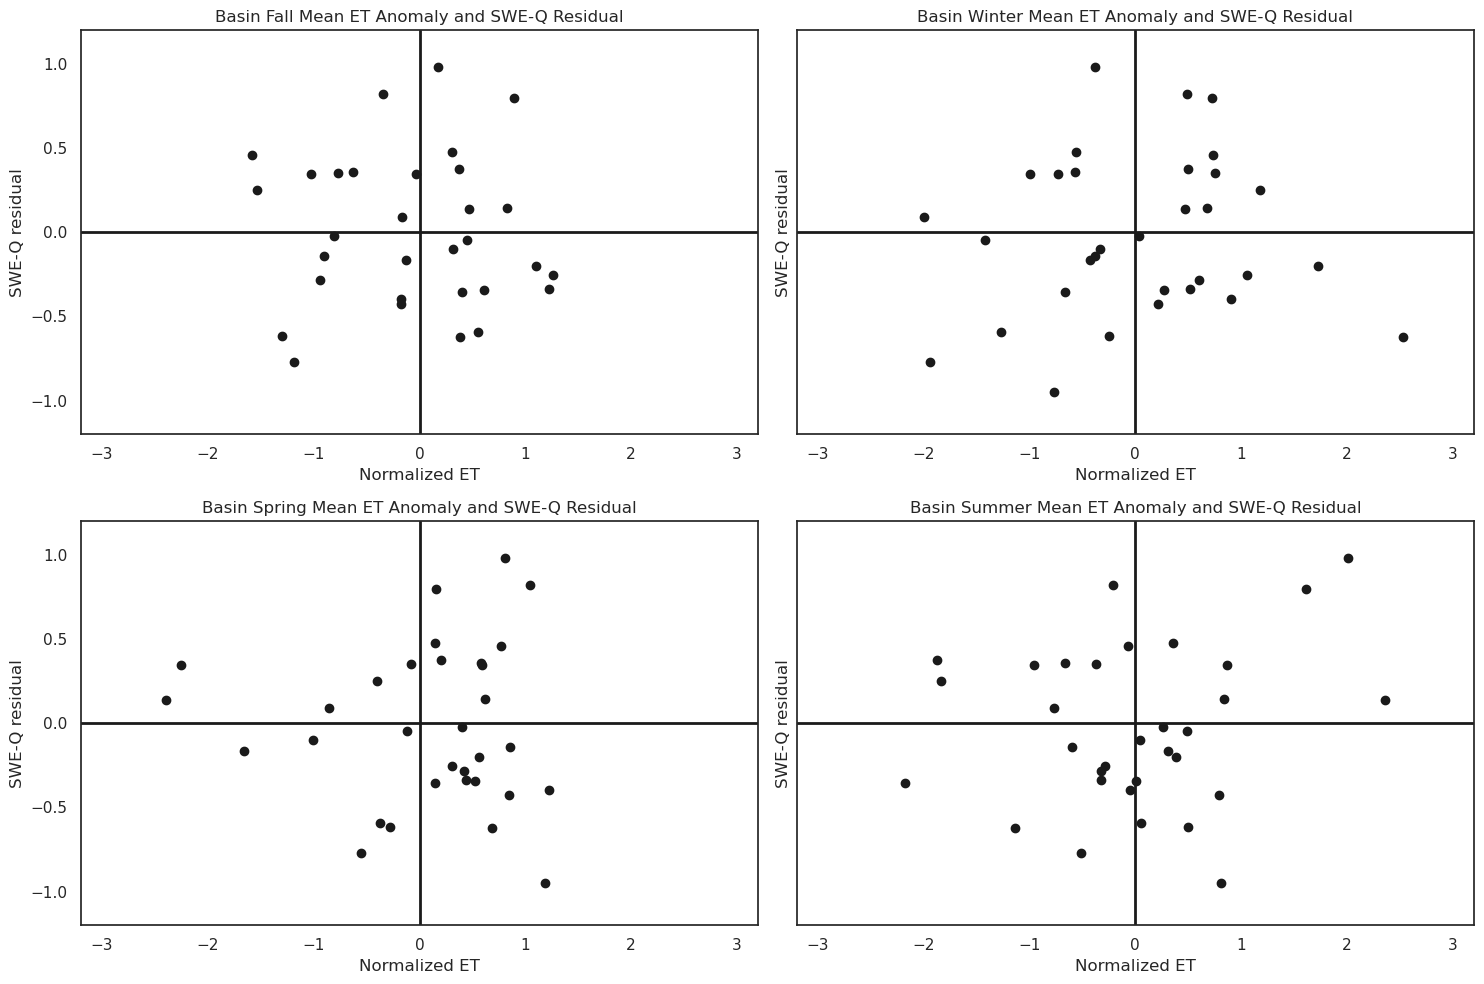

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, sharey=True, figsize=(15,10))

axs = axs.ravel()
seasons = {
    'Fall':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==11]['ET_rate'].iloc[1:],
    'Winter':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2]['ET_rate'],
    'Spring':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5]['ET_rate'],
    'Summer':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==8]['ET_rate']
}

for i,ax in enumerate(axs):
    season = list(seasons.keys())[i]
    ax.scatter(list(seasons.values())[i],residual.iloc[:-1], color='k')
    ax.set_title(f'Basin {season} Mean ET Anomaly and SWE-Q Residual')
    ax.set_ylabel('SWE-Q residual')
    ax.set_xlabel(f'Normalized ET')
    ax.axhline(0, color='k', lw=2)
    ax.axvline(0, color='k', lw=2)
    ax.set_xlim(-3.2,3.2)
    ax.set_ylim(-1.2,1.2)

### Put the rankings side by side

In [70]:
# Annual ordered SWE-Q residual, Fall soil moisture, Winter ET, Annual ET, Winter Precip, Spring Precip
sorted_year_anomaly_df = pd.DataFrame(
    [
        residual.sort_values().index,
        norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].sort_values().index,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2].sort_values(by='ET_rate',ascending=False).WY,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5].sort_values(by='ET_rate',ascending=False).WY,
        sorted_annual_et.index[::-1],
        sorted_annual_precip.index,
        sorted_spring_precip.sort_values(by='precip').WY,
        sorted_winter_precip.sort_values(by='precip').WY,
        sorted_fall_precip.sort_values(by='precip').WY,
        sorted_summer_precip.sort_values(by='precip').WY,
        sorted_spring_precip.sort_values(by='precip', ascending=False).WY,
        norm_sdd.iloc[1:].sort_values().index,
    ],
).T

cols=['SWE-Q residual', "Fall soil moisture", "Winter ET", "Spring ET","Annual ET","Annual Precip", "Spring Precip", "Winter Precip", "Fall Precip", "Summer Precip", "Spring Precip Strength", "SDD"]

sorted_year_anomaly_df = sorted_year_anomaly_df.rename(columns = dict(zip(sorted_year_anomaly_df.columns, cols)))
# sorted_year_anomaly_df = sorted_year_anomaly_df.set_index('SWE-Q residual')


In [71]:
norm_residual = (residual - residual.mean())/residual.std()

In [81]:
taylor_anomaly_df = pd.DataFrame(
    [
        norm_residual.values,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2].ET_rate.values,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5].ET_rate.values,
        norm_wrf_annual_et.ET_rate.values,
        norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].values,
        norm_wrf_annual_precip.precip.values,
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==11].precip.values[:-1],
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==2].precip.values,
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==5].precip.values,
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==8].precip.values,
        norm_sdd.values[1:],
        norm_park_cone_idx_max_df['peak_swe_doy'].values[1:]
    ]
).T

cols=['SWE-Q residual', "Winter ET", "Spring ET","Annual ET", "Antecedent fall\nsoil moisture","Annual Precip", "Fall Precip", "Winter Precip", "Spring Precip", "Summer Precip", "SDD", "Peak SWE DOY"]

taylor_anomaly_df = taylor_anomaly_df.rename(columns = dict(zip(taylor_anomaly_df.columns, cols)))

taylor_anomaly_df.set_index(residual.index,inplace=True)

Text(0.5, 1.0, 'Taylor River Annual/Seasonal Water Flux Anomalies')

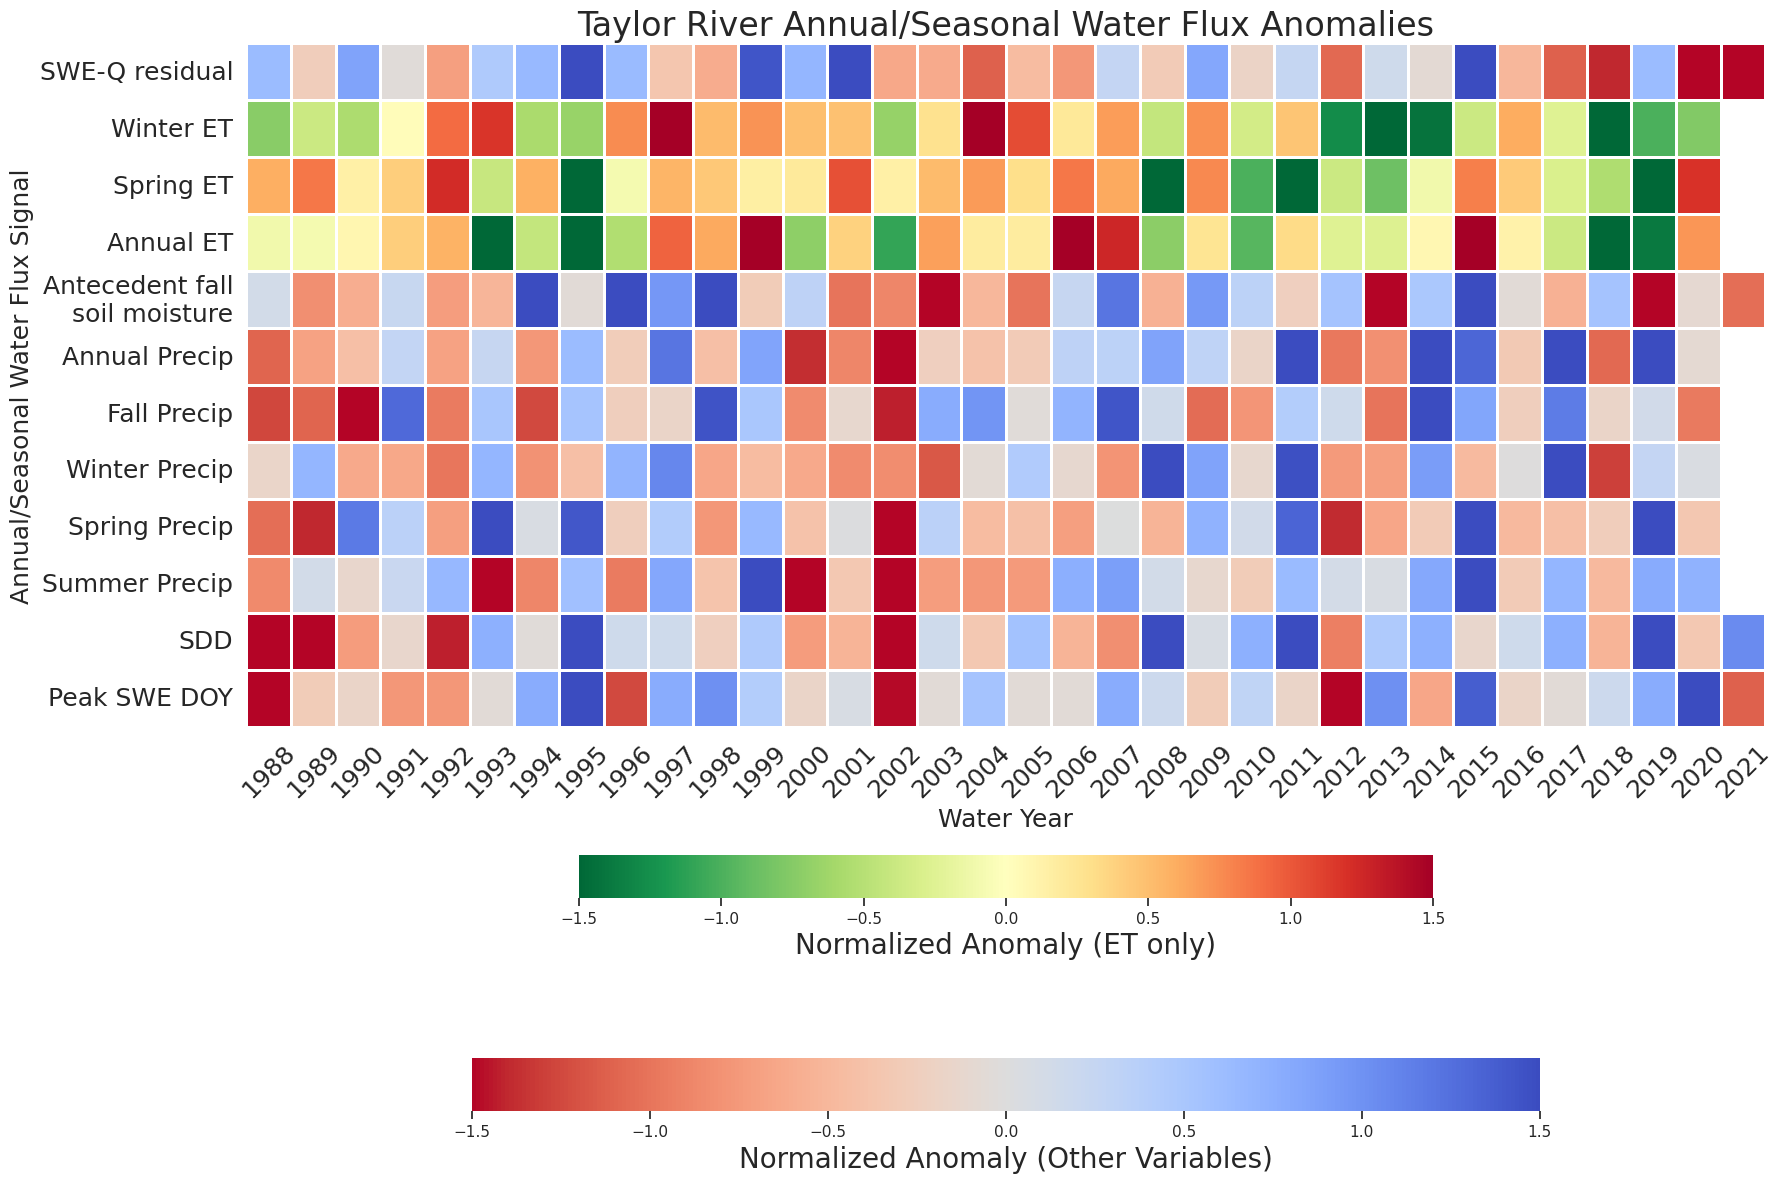

In [83]:
sns.set(font_scale=2)
sns.set_theme(style='white')
fig, ax=plt.subplots(nrows=1,figsize=(18,12), facecolor='w',tight_layout=True)
taylor_anomaly_T = taylor_anomaly_df.T

et_specific =taylor_anomaly_T.copy()
et_specific[~et_specific.index.isin(['Winter ET', 'Spring ET', 'Annual ET'])] = np.nan
sns.heatmap(taylor_anomaly_T, 
            cmap='coolwarm_r', 
            vmin=-1.5, 
            vmax=1.5,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly (Other Variables)',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.figure.axes[-1].xaxis.label.set_size(20)
sns.heatmap(et_specific, 
            cmap='RdYlGn_r', 
            vmin=-1.5, 
            vmax=1.5,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly (ET only)',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.figure.axes[-1].xaxis.label.set_size(20)
ax.set_yticklabels(taylor_anomaly_T.index, rotation=0, ha='right', size=18);
ax.set_xticklabels(taylor_anomaly_T.columns, rotation=45, ha='center', size=18);
ax.set_ylabel('Annual/Seasonal Water Flux Signal',size=18)
ax.set_xlabel('Water Year', size=18)
ax.set_title('Taylor River Annual/Seasonal Water Flux Anomalies', size=24)

In [74]:
sorted_year_anomaly_df

,SWE-Q residual,Fall soil moisture,Winter ET,Spring ET,Annual ET,Annual Precip,Spring Precip,Winter Precip,Fall Precip,Summer Precip,Spring Precip Strength,SDD
0,2020.0,2002.0,2004.0,1992.0,1999.0,2002.0,2002.0,2018.0,1990.0,2002.0,2019.0,2002.0
1,2021.0,2018.0,1997.0,2020.0,2006.0,2000.0,1989.0,2003.0,2002.0,1993.0,2015.0,1988.0
2,2018.0,2012.0,1993.0,2001.0,2015.0,1988.0,2012.0,1992.0,1988.0,2000.0,1993.0,1989.0
3,2004.0,2020.0,2005.0,1989.0,2007.0,2018.0,1988.0,2001.0,1994.0,1996.0,1995.0,1992.0
4,2017.0,2004.0,1992.0,2006.0,1997.0,2012.0,1998.0,2002.0,1989.0,1994.0,2011.0,2012.0
5,2012.0,2000.0,1996.0,2015.0,2020.0,2001.0,2006.0,1994.0,2009.0,1988.0,1990.0,2007.0
6,2006.0,2001.0,2009.0,2009.0,2003.0,2013.0,1992.0,2007.0,2013.0,2004.0,2009.0,1990.0
7,1992.0,1988.0,1999.0,2004.0,1998.0,1994.0,2013.0,2012.0,2020.0,2005.0,1999.0,2000.0
8,2002.0,1991.0,2007.0,2007.0,1992.0,1992.0,2008.0,2013.0,1992.0,2003.0,1997.0,2018.0
9,2003.0,1989.0,2016.0,1988.0,1991.0,1989.0,2016.0,1998.0,2000.0,2018.0,2003.0,2006.0


Notes for the largest negative SWE-Q residual using April 1 SWE - 4/1-9/30 Q

1) 2020: Antecedent soil moisture, fall precip anomaly, annual ET anomaly, 
2) 2021: Antecedent fall soil moisture anomaly
3) 2018: spring precip anomaly, fall precip anomaly, early SDD
4) 2004: weak summer precip anomaly, winter ET anomaly, spring ET anomaly
5) 2017: summer precip anomaly, lots of spring precipitation (Rain or snow?) - springtime swe/P
6) 2012: Annual precip anomaly resulting in soil moisture anomaly, sping precip anomaly, summer precip anomaly, early sdd
7) 2006: winter ET anomaly, spring ET anomaly, annual ET anomaly, summer precip anomaly
8) 1992: spring ET anomaly, annual et anomaly, winter and spring precip anoamly, early sdd, antecedent fall sm
9) 2002: Antecedent fall soil moisture anomaly, annual precip anomaly, spring precip anomaly, winter precip anomaly, fall precip anomaly, summer precip anomaly, early sdd
10) 2003: Antecednet fall soil moisture

**Hypothesis (1) - Antecedent fall soil moisture signal leads to the immediate supply of water from snow in spring to replenish this resource, leaving this water in the root zone for plants.**
- Years that would fall in this category: 2020, 1992, 2021, 2003 

**Hypothesis (2) - Seasonal precipitation anomalies essentially do the same thing, but within a water year, especially if we have a dry winter, spring or fall, more of the melting snow will go towards the supply needed for plants, with snow disappearing earlier**
- Years that would fall in this category: 2002, 2018, 2012, 2017?
- Can I see this in the groundwater data for 2018 (does this year have our lowest groundwater levels?) Yes, we had the lowest groundwater levels during 2018 from the sequence of available data. Showing that drawdown may have been occurring disproportionately

**Hypothesis (3) - ET anomalies during warmer winters/springs remove water from the snowpack that would otherwise flow into the river. Annual ET anomalies may do this year-round with warmer temperatures**
- Years that would fall in this category: 2020, 1992, 2006, 2004
- Do these years correlate with warmer than average winters/springs? Check out billy's climatology to see if this holds true
- Check out elevational bands of ET and years when the highest band hosts the largest anomalies.

Can I get a signal for 2021 and estimate why we had missing water?
Can I test basin wide water balances with ET, SWE, Precip, Soil Moisture (Merra-2), and streamflow
Q = SWE + P - ET - ΔS

Notes for the largest negative SWE-Q residual using April 1 SWE - 4/1-9/30 Q over entire East River
1) 2021 - antecedent soil moisture (2018, 2019, 2020)
2) 2020 - antecedent soil moisture (2018, 2019), summer precip anomaly, spring ET anomaly, annual ET anomaly
3) 2002 - annual precip anomaly, winter precip anomaly, fall precip anomaly, summer precip anomaly, early snow disappearance
4) 2005 - winter ET anomaly, spring ET anomaly, early antecedent snow disappearance, antecedent soil moisture
5) 2003 -  antecedent soil moisture, spring precip anonmaly, weak fall precip anomaly
6) 2004 - winter ET anomaly, spring ET anomaly,  weak summer precip anomaly, early sdd
7) 2008 - weak winter ET anomaly, early antecedent snow melt - check SNTL on this year - it had an extremely late start the snow season (2nd latest in last 35 years), warm spring with precip?, weak antecedent fall soil moisture anomaly
8) 1993 -  antecedent soil moisture, fall precip anomaly, antecedent early SDD, somewhat strong monsoon

To do:
- check snow water equivalent and streamflow during weird looking years
- Run the analysis for the Taylor River Basin... do we come to the same conclusions?
- Build a April 1 SWE to Streamflow plot for nearby basins and check if the sorted residuals fall within the same distribution (wilcoxon rank sum test perhaps?)

### Exploring the odd signals by looking at streamflow and SWE for weird years

Text(0.5, 0, 'Day of WY')

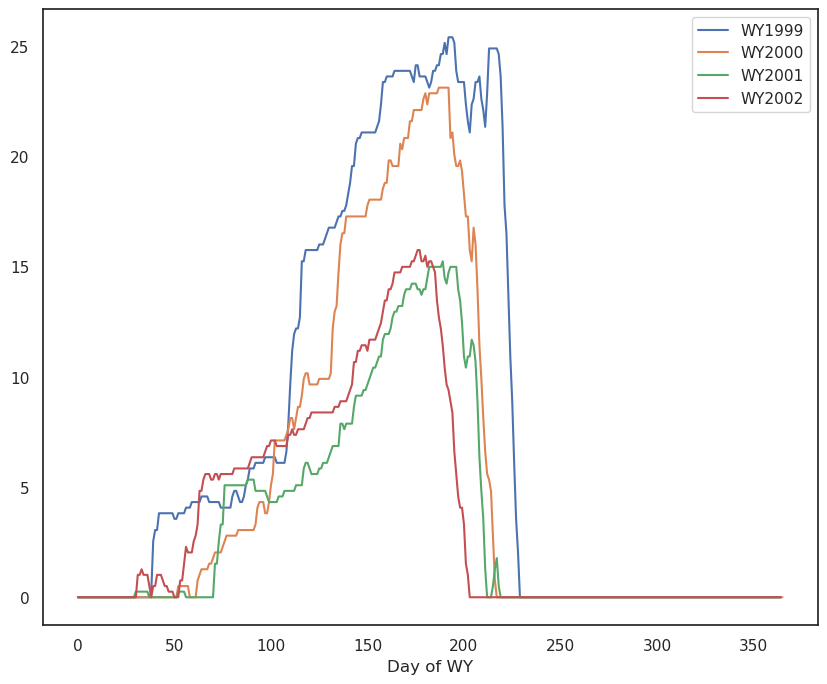

In [75]:
# 2000-2002
# Look at Butte SNTL and Streamflow for 2008
park_cone_1999 = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered['WY']==1999).to_dataframe()['WTEQ'].dropna().reset_index()
park_cone_2000 = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered['WY']==2000).to_dataframe()['WTEQ'].dropna().reset_index()
park_cone_2001 = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered['WY']==2001).to_dataframe()['WTEQ'].dropna().reset_index()
park_cone_2002 = park_cone_mean_ds_filtered.where(park_cone_mean_ds_filtered['WY']==2002).to_dataframe()['WTEQ'].dropna().reset_index()

fig, ax = plt.subplots(figsize=(10,8))

park_cone_1999['WTEQ'].plot(label='WY1999',ax=ax)
park_cone_2000['WTEQ'].plot(label='WY2000',ax=ax)
park_cone_2001['WTEQ'].plot(label='WY2001',ax=ax)
park_cone_2002['WTEQ'].plot(label='WY2002',ax=ax)

ax.legend()
ax.set_xlabel('Day of WY')

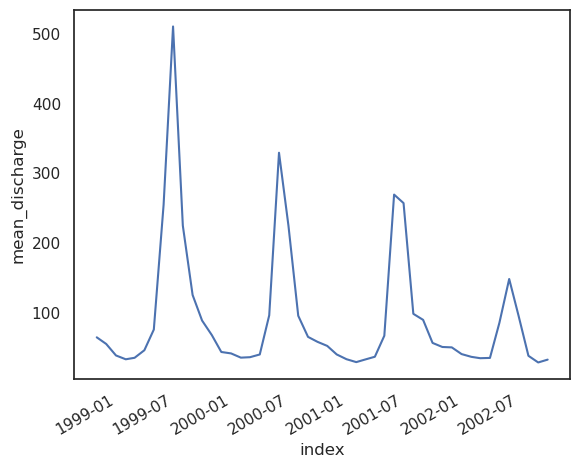

In [76]:
taylor_river_discharge_almont_monthly_ds.sel(index=slice('1998-10-1','2002-10-1'))['mean_discharge'].plot()